# ELO Rating estimation

In [1]:
import json

with open("../rankings.json", "r") as file:
    data = json.load(file)
;

''

<Axes: ylabel='Density'>

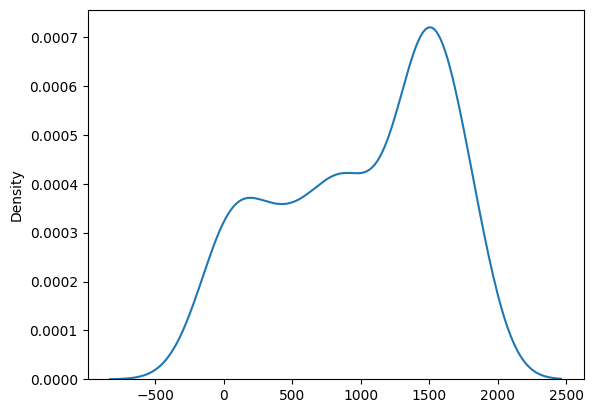

In [2]:
import seaborn as sns

# data contains two dictionaries:
# - data['results'] is a symmetrical matrix containing all the match outcomes between two players
# - data['elo'] contains the estimated elo ratings from the results computed with a simple OLS regression

sns.kdeplot(data=data['elo'])

## Estimating ELO with an OLS regression

<Axes: ylabel='Density'>

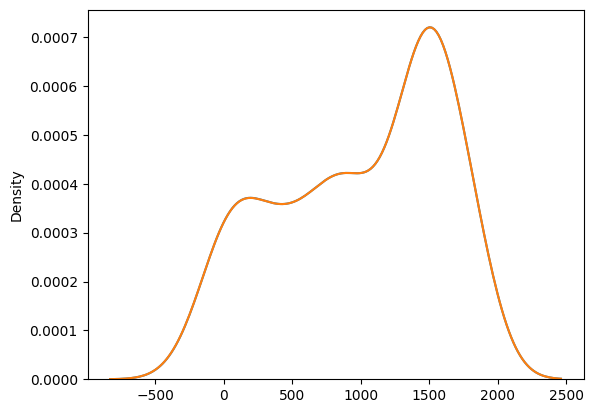

In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression


def match_two_hot(i1: int, i2: int, n: int) -> np.ndarray:
    x = np.zeros(n)
    x[i1] = 1
    x[i2] = -1
    return x

def score_from_results(results): # Includes a Jeffreys Prior
    return (results[0] - results[2]) / (sum(results) + 1)

# Data should be a symmetric 2d dictionary
#
def compute_elo(data, sk=True):
    players = list(data.keys())
    player_id = {
        players[i]: i
        for i in range(len(players))
    }

    matches = [
        (player1, player2)
        for player1 in players
        for player2 in data[player1].keys()
        if player1 < player2
    ]

    X = np.array([
        match_two_hot(player_id[player1], player_id[player2], len(players))
        for player1, player2 in matches
    ] + [
        [1] * len(players)
    ])
    y = np.concatenate([
        -(400 / np.log(10)) * np.log(1 / np.clip(np.array([
            (score_from_results(data[player1][player2]) + 1) / 2
            for player1, player2 in matches
        ]), 1e-10, 1-1e-10) - 1),
        [1000 * len(players)] # We set the average elo to 1000
    ])
    w = np.concatenate([
        [sum(data[player1][player2]) for player1, player2 in matches],
        [1]
    ])
    # We solve XR=y, with R the elo ratings of the players
    reg = LinearRegression(fit_intercept=False).fit(X, y, sample_weight=w)
    elo = reg.coef_
    return dict(sorted({
        player: elo[i]
        for i, player in enumerate(players)
    }.items()))

elos = compute_elo(data['results'])
# elos should be the same as data['elo']
sns.kdeplot(data=data['elo'])
sns.kdeplot(data=elos)

In [4]:
def make_range(config, offset=0):
    return range(config['start']+offset, config['end']+offset, config['step'])

# We group players coming from the same model run together

evr = {
    'chess_2024-04-28:21h03': {
        'start': 1,
        'end': 100,
        'step': 2,
        'label': 'fine-tuned 8 layers',
    },
    'chess_2024-04-06:22h14': {
        'start': 1,
        'end': 20,
        'step': 2,
        'label': 'fine-tuned 6 layers',
    },
    'chess_2024-03-25:18h42': {
        'start': 9,
        'end': 100,
        'step': 10,
        'label': 'base 5 layers',
    },
    'chess_2024-04-18:17h03': {
        'start': 4,
        'end': 100,
        'step': 5,
        'label': 'AlphaZero 5 layers',
    },
    'chess_2024-05-08:14h24': {
        'start': 1,
        'end': 100,
        'step': 2,
        'label': 'sparse 5 layers',
    },
    'chess_2024-05-10:15h27': {
        'start': 1,
        'end': 100,
        'step': 2,
        'label': 'dense 5 layers',
    },
    'gardner_chess_2024-04-04:17h15': {
        'start': 9,
        'end': 100,
        'step': 10,
        'label': 'gardner',
    },
    'chess_2024-05-20:14h19': {
        'start': 1,
        'end': 34,
        'step': 2,
        'label': 'AlphaGateau 5 layers',
    },
}
for model, config in evr.items():
    evr[model]['elo_ols'] = [
        elos[f"{model}/{it:03}"]
        for it in make_range(config)
    ]

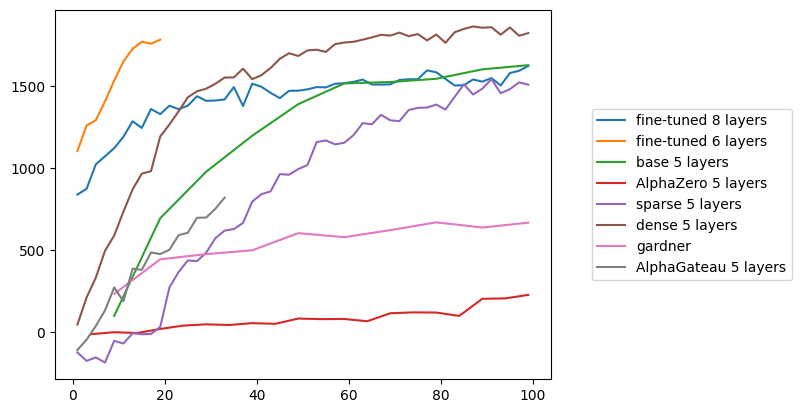

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for model, m_data in evr.items():
    ax.plot(make_range(m_data), m_data['elo_ols'], label=m_data['label'])
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

### Manual Linear Regression

In [6]:
players = list(data['results'].keys())
players[:5]

['chess_2024-03-25:18h42/089',
 'chess_2024-03-25:18h42/099',
 'chess_2024-03-25:18h42/079',
 'chess_2024-04-06:22h14/015',
 'chess_2024-03-25:18h42/059']

In [7]:
player_id = {
    players[i]: i
    for i in range(len(players))
}

In [8]:
matches = [
    (player1, player2)
    for player1 in players
    for player2 in data['results'][player1].keys()
    if player1 < player2
]
matches[:5]

[('chess_2024-03-25:18h42/089', 'chess_2024-03-25:18h42/099'),
 ('chess_2024-03-25:18h42/089', 'chess_2024-04-06:22h14/013'),
 ('chess_2024-03-25:18h42/089', 'chess_2024-04-06:22h14/007'),
 ('chess_2024-03-25:18h42/089', 'chess_2024-04-06:22h14/009'),
 ('chess_2024-03-25:18h42/089', 'chess_2024-04-06:22h14/003')]

In [9]:
X = np.array([
    match_two_hot(player_id[player1], player_id[player2], len(players))
    for player1, player2 in matches
] + [
    [1] * len(players)
])
r_bar = np.array([
    score_from_results(data['results'][player1][player2])
    for player1, player2 in matches
])
p_bar = (r_bar + 1) / 2
y = np.concatenate([
    -(400 / np.log(10)) * np.log(1 / p_bar - 1),
    [1000 * len(players)] # We set the average elo to 1000
])
w = np.concatenate([
    [sum(data['results'][player1][player2]) for player1, player2 in matches],
    [1]
])

In [10]:
X.shape, X[:5]

((1572, 255),
 array([[ 1., -1.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 1.,  0.,  0., ...,  0.,  0.,  0.]]))

In [11]:
y.shape, y[:5]

((1572,),
 array([  22.81540039, -172.35042671,  172.35042671,   81.18536218,
         235.53269024]))

In [12]:
w.shape, w[-10:]

((1572,), array([60, 60, 60, 60, 60, 60, 60, 60, 60,  1]))

In [13]:
reg = LinearRegression(fit_intercept=False).fit(X, y, sample_weight=w)
elos_manual = dict(sorted({
    player: reg.coef_[i]
    for i, player in enumerate(players)
}.items()))
elos_manual['chess_2024-04-28:21h03/099']

def check(dic1, dic2):
    if set(dic1.keys()) != set(dic2.keys()):
        return False
    for key in dic1.keys():
        if dic1[key] != dic2[key]:
            print(key,  dic1[key], dic2[key])
            return False
    return True
check(elos, elos_manual)

True

In [14]:
sum(reg.coef_) / len(players)

1000.0000000000014

## Estimating ELO and Confidence Intervals with an WLS regression

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy import stats
from statsmodels.iolib.table import SimpleTable, default_txt_fmt

np.random.seed(1024)

In [16]:
# We compute the variance linked to the normal approximation to the rating differences, following Eq~15
# w contains the number of games for each match, with an extra 1 at the end

var = (400 / np.log(10)) ** 2 / (w[:-1] * p_bar * (1-p_bar))
var[96:99], w[96:99], p_bar[96:99]

(array([2160.49754561, 2067.41894381, 2056.6274713 ]),
 array([60, 60, 60]),
 array([0.63114754, 0.58196721, 0.57377049]))

In [17]:
# We need to set a low variance > 0 for the last equation, whose role is only to set the mean rating, which can be chosen arbitrarily
var = np.concatenate([var,[1e-7]])

In [18]:
var.shape

(1572,)

In [19]:
mod_wls = sm.WLS(y, X, weights=1.0 / var)
res_wls = mod_wls.fit()
print(res_wls.summary())

                                 WLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            WLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.066e+15
Date:                Wed, 22 May 2024   Prob (F-statistic):                        0.00
Time:                        15:41:46   Log-Likelihood:                         -8516.3
No. Observations:                1572   AIC:                                  1.754e+04
Df Residuals:                    1317   BIC:                                  1.891e+04
Df Model:                         255                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [20]:
res_wls.bse[player_id['gardner_chess_2024-04-22:18h50/009']]

31.71528973497731

In [21]:
sum(res_wls.params) / len(players)

999.999999999999

In [22]:
elos_wls = dict(sorted({
    player: res_wls.params[i]
    for i, player in enumerate(players)
}.items()))
# The standard deviations derived from the WLS
sds_wls = dict(sorted({
    player: res_wls.bse[i]
    for i, player in enumerate(players)
}.items()))
elos_wls['chess_2024-04-28:21h03/099'], sds_wls['chess_2024-04-28:21h03/099']

(1673.3363989587267, 17.63140037817479)

In [23]:
from scipy.stats import norm

ic = 0.95
ic = 0.99999943
norm.ppf(1-(1-ic)/2)

5.001113980125975

In [24]:
ic = 0.95
sigma = norm.ppf(1-(1-ic)/2)
sigma = 2
for model, config in evr.items():
    evr[model]['elo_wls'] = [
        elos_wls[f"{model}/{it:03}"]
        for it in make_range(config)
    ]
    evr[model]['sd_wls'] = [
        sds_wls[f"{model}/{it:03}"]
        for it in make_range(config)
    ]
    evr[model]['ci_wls'] = sigma * np.array(evr[model]['sd_wls'])

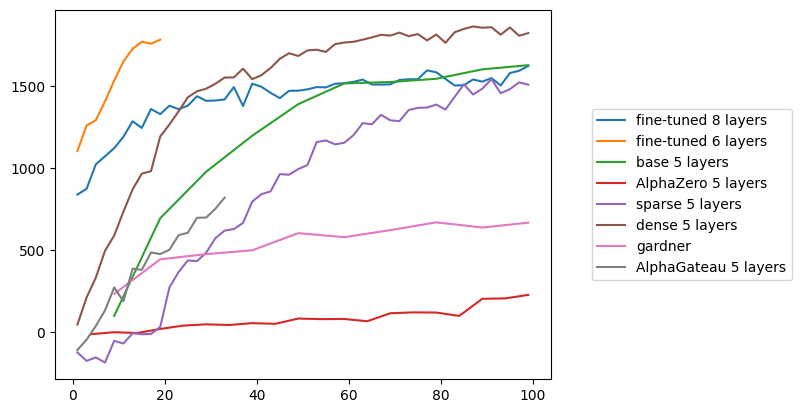

In [25]:
# OLS ELO

fig, ax = plt.subplots()
for model, m_data in evr.items():
    ax.plot(make_range(m_data), m_data['elo_ols'], label=m_data['label'])
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

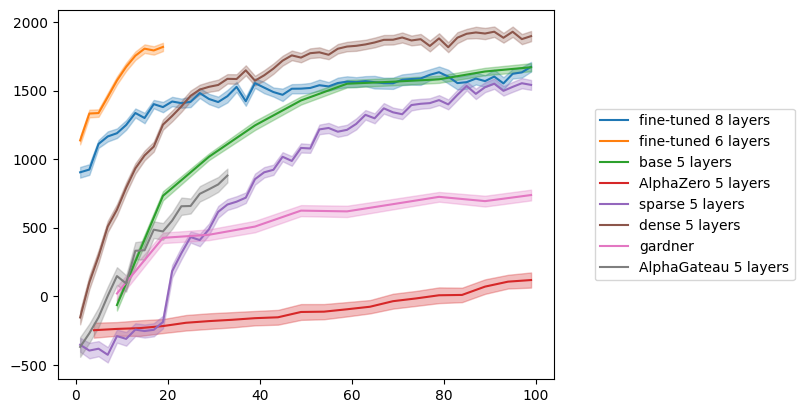

In [26]:
# WLS ELO

fig, ax = plt.subplots()
for i, (model, m_data) in enumerate(evr.items()):
    ax.plot(make_range(m_data), m_data['elo_wls'], label=m_data['label'])
    ax.fill_between(
        make_range(m_data),
        m_data['elo_wls'] - m_data['ci_wls'],
        m_data['elo_wls'] + m_data['ci_wls'],
        alpha=0.3,
        color=f"C{i}"
    )
ax.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

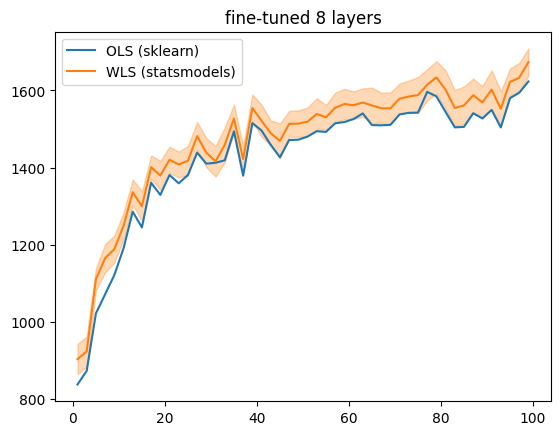

In [27]:
def compare_ols_wls(model, title):
    plt.plot(make_range(evr[model]), evr[model]['elo_ols'], label="OLS (sklearn)")
    plt.plot(make_range(evr[model]), evr[model]['elo_wls'], label="WLS (statsmodels)")
    plt.fill_between(
        make_range(evr[model]),
        evr[model]['elo_wls'] - evr[model]['ci_wls'],
        evr[model]['elo_wls'] + evr[model]['ci_wls'],
        alpha=0.3,
        color="C1"
    )
    plt.title(title)
    plt.legend()

compare_ols_wls('chess_2024-04-28:21h03', 'fine-tuned 8 layers')

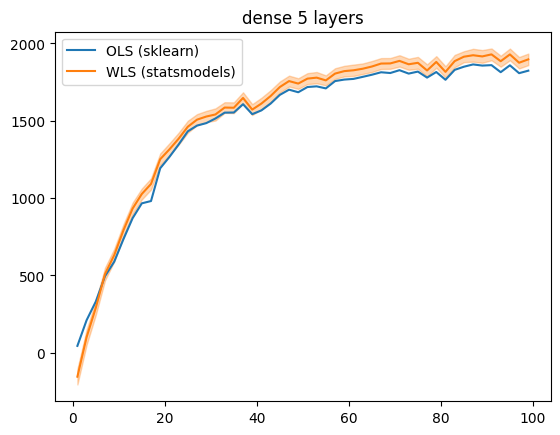

In [28]:
compare_ols_wls('chess_2024-05-10:15h27', 'dense 5 layers')

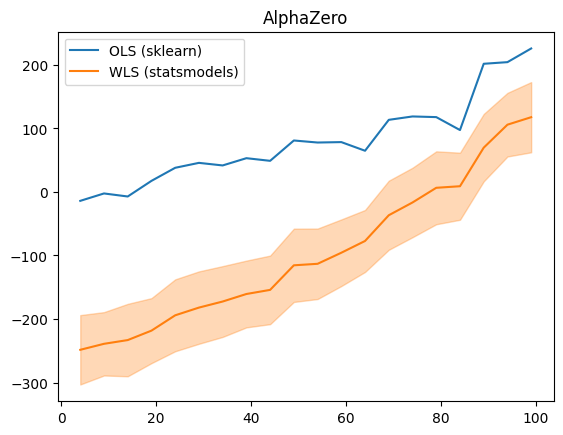

In [29]:
compare_ols_wls('chess_2024-04-18:17h03', 'AlphaZero')

In [30]:
def print_elo_approx(model, it):
    print(evr[model]['elo_wls'][it], '±', evr[model]['sd_wls'][it])
    print(f"{evr[model]['elo_wls'][it]:.0f} ± {evr[model]['sd_wls'][it]:.0f}")

# AlphaZero last ELO
print_elo_approx('chess_2024-04-18:17h03', -1)

117.5948485523192 ± 27.616560001948592
118 ± 28


In [31]:
# AlphaGateau last ELO
print_elo_approx('chess_2024-03-25:18h42', -1)

1670.0873295819276 ± 14.739239482240752
1670 ± 15


In [32]:
# 5x5 training last ELO
print_elo_approx('gardner_chess_2024-04-04:17h15', -1)

737.7040882369105 ± 19.65748086028134
738 ± 20


In [33]:
# 5x5 training last ELO
print_elo_approx('chess_2024-04-06:22h14', -1)

1818.3774742283117 ± 15.134412155363956
1818 ± 15


In [34]:
from cycler import cycler

monochrome = (cycler('linestyle', ['-', '--', ':']) * cycler('marker', ['^',',', '.']))

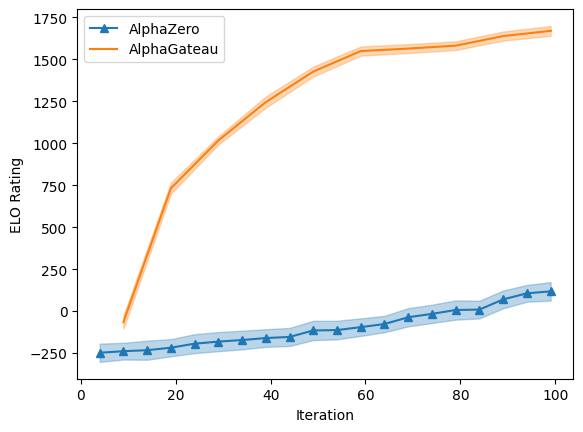

In [35]:
def clean_plot(model_names, labels):
    fig, ax = plt.subplots()
    ax.set_prop_cycle(monochrome)
    for i, (model_name, label) in enumerate(zip(model_names, labels)):
        model = None
        for m in evr.keys():
            if evr[m]['label'] == model_name:
                model = m
        m_data = evr[model]
        ax.plot(make_range(m_data), m_data['elo_wls'], label=label, color=f"C{i}")
        ax.fill_between(
            make_range(m_data),
            m_data['elo_wls'] - m_data['ci_wls'],
            m_data['elo_wls'] + m_data['ci_wls'],
            alpha=0.3,
            color=f"C{i}"
        )
    pos = ax.get_position()
    ax.set_xlabel('Iteration')
    ax.set_ylabel('ELO Rating')
    ax.legend()
    return fig
    
fig = clean_plot(['AlphaZero 5 layers', 'base 5 layers'], ['AlphaZero', 'AlphaGateau'])
fig.savefig('../figures/exp1.pdf')

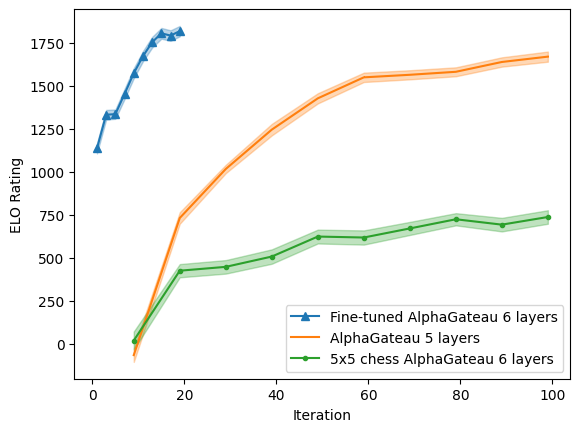

In [36]:
fig = clean_plot(['fine-tuned 6 layers', 'base 5 layers', 'gardner'], ['Fine-tuned AlphaGateau 6 layers', 'AlphaGateau 5 layers', '5x5 chess AlphaGateau 6 layers'])
fig.savefig('../figures/exp2.pdf')

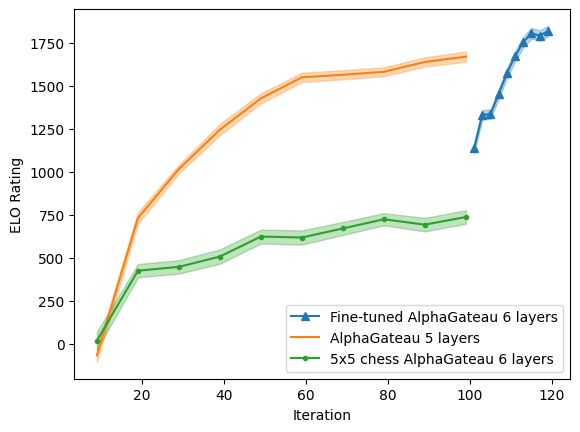

In [37]:
model_names, labels = ['fine-tuned 6 layers', 'base 5 layers', 'gardner'], ['Fine-tuned AlphaGateau 6 layers', 'AlphaGateau 5 layers', '5x5 chess AlphaGateau 6 layers']

fig, ax = plt.subplots()
ax.set_prop_cycle(monochrome)
for i, (model_name, label) in enumerate(zip(model_names, labels)):
    model = None
    for m in evr.keys():
        if evr[m]['label'] == model_name:
            model = m
    m_data = evr[model]
    x = make_range(m_data, offset=(100 if i == 0 else 0))
    ax.plot(x, m_data['elo_wls'], label=label, color=f"C{i}")
    ax.fill_between(
        x,
        m_data['elo_wls'] - m_data['ci_wls'],
        m_data['elo_wls'] + m_data['ci_wls'],
        alpha=0.3,
        color=f"C{i}"
    )
pos = ax.get_position()
ax.set_xlabel('Iteration')
ax.set_ylabel('ELO Rating')
ax.legend()

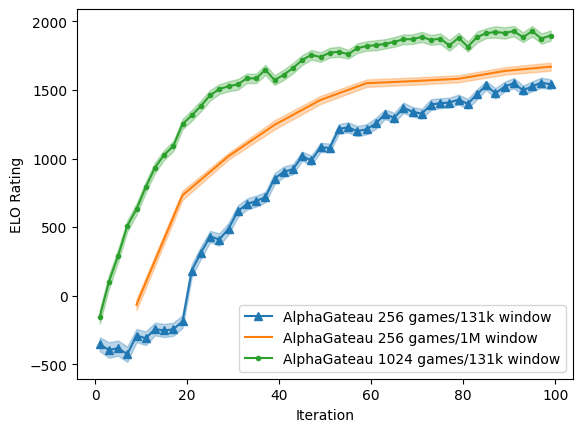

In [38]:
fig = clean_plot(['sparse 5 layers', 'base 5 layers', 'dense 5 layers'], ['AlphaGateau 256 games/131k window', 'AlphaGateau 256 games/1M window', 'AlphaGateau 1024 games/131k window'])
fig.savefig('../figures/exp3.pdf')

In [39]:
evr['chess_2024-05-10:15h27']['elo_wls']

[-155.33110462194838,
 100.22963505454578,
 290.40478263001506,
 508.56642713464515,
 630.5163588332466,
 790.6770577453652,
 932.0445660389562,
 1026.4672801524819,
 1091.092740956816,
 1251.3178335152452,
 1314.733690257727,
 1383.7643262257939,
 1461.4197273964523,
 1507.0829971405897,
 1527.1583982817767,
 1540.7022116864941,
 1585.3724044963744,
 1584.1417964246061,
 1647.4314814489935,
 1572.132101034265,
 1611.2524430283497,
 1659.9231062722854,
 1718.0737852706434,
 1756.547486858205,
 1740.4341084113962,
 1772.4538766608048,
 1778.8422854197552,
 1761.0569179408278,
 1805.0040287096822,
 1820.955515251574,
 1826.328291488403,
 1836.379363988262,
 1850.7300606901586,
 1869.9372773547132,
 1870.7741814561896,
 1887.1292470056155,
 1865.3190029069915,
 1874.737741140587,
 1825.2012403849303,
 1880.4394134177983,
 1816.1368092317855,
 1885.7798456601997,
 1914.230714440591,
 1923.765293278388,
 1916.0352798966196,
 1929.3179585599523,
 1885.0482744273788,
 1928.991985762717,
 1875

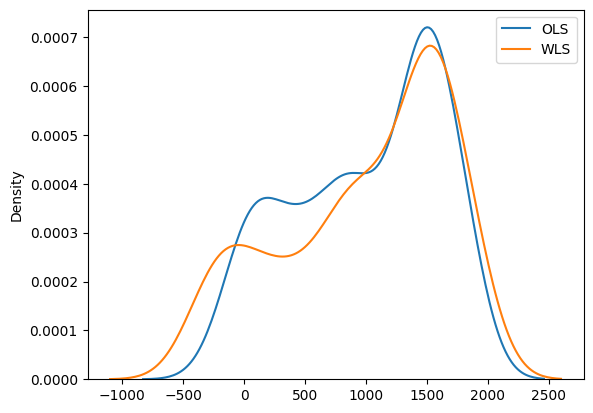

In [40]:
sns.kdeplot(data=data['elo'], label='OLS')
sns.kdeplot(data=res_wls.params, label='WLS')
plt.legend()

Text(0.5, 1.0, 'Standard Errors')

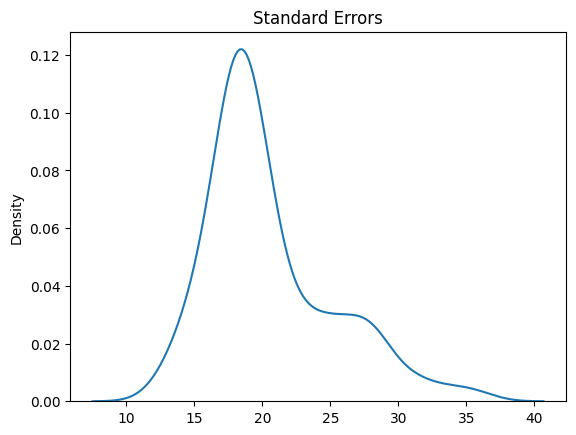

In [41]:
sns.kdeplot(data=res_wls.bse)
plt.title("Standard Errors")

In [42]:
elos_manual['chess_2024-05-10:15h27/099']

1823.8376340901245

In [43]:
for opp, res in data['results']['chess_2024-05-10:15h27/099'].items():
    print(f"{opp}[{elos_manual[opp]:.0f}] {(res[0] - res[2]) / sum(res): .3f} {sum(res)}")

chess_2024-04-28:21h03/007[1072]  0.883 60
chess_2024-04-06:22h14/009[1534]  0.667 60
chess_2024-04-06:22h14/011[1650]  0.450 60
chess_2024-05-10:15h27/055[1709]  0.483 60
chess_2024-05-10:15h27/061[1771]  0.317 60
chess_2024-05-10:15h27/057[1757]  0.300 60
chess_2024-05-10:15h27/063[1784]  0.300 60
chess_2024-05-10:15h27/069[1809]  0.008 120
chess_2024-05-10:15h27/079[1815] -0.017 60
chess_2024-05-10:15h27/073[1805]  0.117 60
chess_2024-05-10:15h27/097[1808]  0.217 60
chess_2024-05-10:15h27/075[1818]  0.100 60
chess_2024-05-10:15h27/093[1814]  0.083 60


In [44]:
data['results']['chess_2024-05-10:15h27/099']

{'chess_2024-04-28:21h03/007': [53, 7, 0],
 'chess_2024-04-06:22h14/009': [45, 10, 5],
 'chess_2024-04-06:22h14/011': [37, 13, 10],
 'chess_2024-05-10:15h27/055': [38, 13, 9],
 'chess_2024-05-10:15h27/061': [32, 15, 13],
 'chess_2024-05-10:15h27/057': [30, 18, 12],
 'chess_2024-05-10:15h27/063': [30, 18, 12],
 'chess_2024-05-10:15h27/069': [41, 39, 40],
 'chess_2024-05-10:15h27/079': [20, 19, 21],
 'chess_2024-05-10:15h27/073': [23, 21, 16],
 'chess_2024-05-10:15h27/097': [31, 11, 18],
 'chess_2024-05-10:15h27/075': [23, 20, 17],
 'chess_2024-05-10:15h27/093': [18, 29, 13]}

In [45]:
evr['chess_2024-05-10:15h27']

{'start': 1,
 'end': 100,
 'step': 2,
 'label': 'dense 5 layers',
 'elo_ols': [43.96887973367089,
  209.86971073056247,
  330.52530998080607,
  494.4931703260913,
  588.2721688014954,
  733.63368294532,
  869.7649839684923,
  965.8220573085216,
  980.7549799931244,
  1192.689106708613,
  1265.9435922993075,
  1346.3103727097775,
  1431.6904885151214,
  1468.7337690631591,
  1484.5461181722833,
  1514.6018829793015,
  1552.4773124560184,
  1553.3134431523713,
  1607.005472541067,
  1542.6611387436105,
  1567.1185489145396,
  1611.0361101914518,
  1667.3840319136607,
  1700.941650620041,
  1684.370809620184,
  1718.1177904722376,
  1722.5362491166043,
  1709.2664341984764,
  1756.532510928483,
  1766.2734690122093,
  1770.5982776470548,
  1783.8195017026635,
  1797.5889954090103,
  1813.6047385565423,
  1808.6726173434165,
  1826.9660546210068,
  1804.9854412046204,
  1817.9491619444645,
  1779.0872318607153,
  1815.194334981372,
  1765.0369214708082,
  1829.1269512153156,
  1849.4273471

In [46]:
res_wls.params[233], players[233]

(1929.3179585599523, 'chess_2024-05-10:15h27/091')